# Deep Learning for Satellite Image Classification

## Milestone 4

* Set up both S2Cloudless and NWPU images
* Augment images using Data Generator.  Number of augmented images is set by AUGMENTATION_SZ
* Train U-Net using original + augmented data and label (masks).  Epoch is set by EPOCHS
* Run prediction and calculate IoU
* See how well the model is predicting (recognizing) water on surface.


In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import json, os, glob
import zipfile
import shutil
import rasterio
from tqdm import tqdm

In [2]:
DATA_DIR = '/home/aki/ManningLiveProjects/2_Data/'
TRAIN_DIR = '/home/aki/ManningLiveProjects/4_Training/'

EPOCHS = 100
AUGMENTATION_SZ = 200

In [3]:
# Copy S2 images
shutil.rmtree(TRAIN_DIR+'s2cloudless_imagery', ignore_errors=True)
shutil.rmtree(TRAIN_DIR+'s2cloudless_label_imagery', ignore_errors=True)

zipfile.ZipFile(DATA_DIR+'s2cloudless_imagery.zip', 'r').extractall(TRAIN_DIR)
zipfile.ZipFile(DATA_DIR+'s2cloudless_label_imagery.zip','r').extractall(TRAIN_DIR)


In [4]:
# Copy NWPU images
shutil.rmtree(TRAIN_DIR+'nwpu_images', ignore_errors=True)
shutil.rmtree(TRAIN_DIR+'nwpu_label_images', ignore_errors=True)

zipfile.ZipFile(DATA_DIR+'nwpu_images.zip', 'r').extractall(TRAIN_DIR)
zipfile.ZipFile(DATA_DIR+'nwpu_label_images.zip','r').extractall(TRAIN_DIR)

Load multiple VGG-JSON into a dict.  Dict key is the image file name.

In [5]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [6]:
def unet(sz = (512, 512, 3)):
    inputs = Input(sz)
    _ = inputs
  
    #down sampling 
    f = 8
    layers = []
  
    for i in range(0, 6):
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      layers.append(_)
      _ = MaxPooling2D() (_)
      f = f*2
    ff2 = 64 
  
    #bottleneck 
    j = len(layers) - 1
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
    _ = Concatenate(axis=3)([_, layers[j]])
    j = j -1 
  
    #upsampling 
    for i in range(0, 5):
      ff2 = ff2//2
      f = f // 2 
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      _ = Conv2D(f, 3, activation='relu', padding='same') (_)
      _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
      _ = Concatenate(axis=3)([_, layers[j]])
      j = j -1 
    
    #classification 
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    outputs = Conv2D(1, 1, activation='sigmoid') (_)
  
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
    return model  


In [7]:
checkpointer_nwpu = tf.keras.callbacks.ModelCheckpoint(filepath='nwpu_unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
checkpointer_s2 = tf.keras.callbacks.ModelCheckpoint(filepath='s2cloudless_unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
      

In [8]:
def image_batch_generator(path, files, mask_threshold, mask_rename, batch_size = 32, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = path+"/data/"+f
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace(mask_rename[0], mask_rename[1])+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>mask_threshold).astype('int')
        
        mask = mask[:n,:n]

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

In [9]:
def augment_generators(img_path, label_path):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=False,
            featurewise_std_normalization=False,     
            shear_range=0,
            zoom_range=0.2,
            rotation_range=45,
            horizontal_flip=True)

    img_generator = train_datagen.flow_from_directory(    
            img_path,
            target_size=(2048, 2048), #opt for a fairly small image size for memory efficiency
            batch_size=1,
            class_mode=None, 
            seed=111, 
            shuffle=False)

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=False,
            featurewise_std_normalization=False,     
            shear_range=0,
            zoom_range=0.2,
            rotation_range=45,
            horizontal_flip=True)

    mask_generator = test_datagen.flow_from_directory(
            label_path,
            target_size=(2048, 2048),
            batch_size=1,
            class_mode=None, 
            seed=111, 
            shuffle=False)
    return img_generator, mask_generator

def augment_images(img_path, label_path):
    pbar = tqdm(total=AUGMENTATION_SZ)
    counter = 0
    img_gen, mask_gen = augment_generators(img_path, label_path)
    aug_gen = (tuple(np.array(pair, dtype='float64')/255) for pair in zip(img_gen, mask_gen))

    while counter < AUGMENTATION_SZ:
        pbar.update(1)
        x, y = next(aug_gen)
        matplotlib.image.imsave(label_path +"/data/augimage00"+str(counter)+".jpg_mask.jpg", np.squeeze(y[0])) 
        matplotlib.image.imsave(img_path+"/data/augimage00"+str(counter)+".jpg", np.squeeze(x[0]))    
        counter += 1

In [10]:
batch_size = 8
prop_train = 0.6



In [11]:
! rm -f {TRAIN_DIR+"s2cloudless_label_imagery/data/aug*.jpg"}
! rm -f {TRAIN_DIR+"s2cloudless_imagery/data/aug*.jpg"}

! rm -f {TRAIN_DIR+"nwpu_images/data/aug*.jpg"}
! rm -f {TRAIN_DIR+"nwpu_label_images/data/aug*.jpg"}

augment_images(TRAIN_DIR+'nwpu_images', TRAIN_DIR+'nwpu_label_images')
augment_images(TRAIN_DIR+'s2cloudless_imagery', TRAIN_DIR+'s2cloudless_label_imagery')

  0%|          | 0/200 [00:00<?, ?it/s]

Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


100%|██████████| 200/200 [05:16<00:00,  1.58s/it]


In [12]:
def get_train_test(path, batch_size, prop_train, mask_threshold, mask_rename):
    all_files = os.listdir(path+'/data')
    shuffle(all_files)
    print(path)

    split = int(prop_train * len(all_files))

    #split into training and testing
    train_files = all_files[0:split]
    test_files  = all_files[split:]

    train_steps = len(train_files) //batch_size
    test_steps = len(test_files) //batch_size

    print(train_steps)
    print(test_steps)

    train_generator = image_batch_generator(path, train_files, mask_threshold, mask_rename, batch_size=batch_size)
    test_generator  = image_batch_generator(path, test_files, mask_threshold, mask_rename, batch_size=batch_size)
    return train_generator, test_generator, train_steps, test_steps, test_files

In [13]:
train_gen, test_gen, train_steps, test_steps, nwpu_test_files = get_train_test(TRAIN_DIR+'nwpu_images', 
                                                              batch_size, 
                                                              prop_train, 
                                                              200, 
                                                              ('nwpu_images','nwpu_label_images'))
model_nwpu = unet()

model_nwpu.fit(
    x=train_gen,
    steps_per_epoch = train_steps,
    validation_data = test_gen,
    validation_steps = test_steps,
    batch_size=batch_size,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[checkpointer_nwpu]
)

/home/aki/ManningLiveProjects/4_Training/nwpu_images
20
13
Epoch 1/100
20/20 [==============================] - 21s 1s/step - loss: 1.0917 - mean_iou: 1.4889e-04 - val_loss: 0.4745 - val_mean_iou: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 22s 1s/step - loss: 0.4274 - mean_iou: 0.0257 - val_loss: 0.3187 - val_mean_iou: 0.5799
Epoch 3/100
20/20 [==============================] - 21s 1s/step - loss: 0.3990 - mean_iou: 0.4500 - val_loss: 0.3199 - val_mean_iou: 0.5248
Epoch 4/100
20/20 [==============================] - 22s 1s/step - loss: 0.3031 - mean_iou: 0.5928 - val_loss: 0.2461 - val_mean_iou: 0.6994
Epoch 5/100
20/20 [==============================] - 22s 1s/step - loss: 0.2960 - mean_iou: 0.5684 - val_loss: 0.2059 - val_mean_iou: 0.7096
Epoch 6/100
20/20 [==============================] - 22s 1s/step - loss: 0.3513 - mean_iou: 0.5020 - val_loss: 0.3478 - val_mean_iou: 0.4059
Epoch 7/100
20/20 [==============================] - 21s 1s/step - loss: 0.3025 - mean_

20/20 [==============================] - 21s 1s/step - loss: 0.1624 - mean_iou: 0.7596 - val_loss: 0.1171 - val_mean_iou: 0.8298
Epoch 57/100
20/20 [==============================] - 21s 1s/step - loss: 0.1463 - mean_iou: 0.7697 - val_loss: 0.1493 - val_mean_iou: 0.7686
Epoch 58/100
20/20 [==============================] - 21s 1s/step - loss: 0.1814 - mean_iou: 0.7242 - val_loss: 0.1551 - val_mean_iou: 0.8004
Epoch 59/100
20/20 [==============================] - 22s 1s/step - loss: 0.1157 - mean_iou: 0.8094 - val_loss: 0.1206 - val_mean_iou: 0.8290
Epoch 60/100
20/20 [==============================] - 21s 1s/step - loss: 0.1449 - mean_iou: 0.7895 - val_loss: 0.1705 - val_mean_iou: 0.7842
Epoch 61/100
20/20 [==============================] - 21s 1s/step - loss: 0.1188 - mean_iou: 0.8047 - val_loss: 0.1467 - val_mean_iou: 0.7814
Epoch 62/100
20/20 [==============================] - 21s 1s/step - loss: 0.1215 - mean_iou: 0.8109 - val_loss: 0.1540 - val_mean_iou: 0.8238
Epoch 63/100
20/20 

In [14]:
train_gen, test_gen, train_steps, test_steps, s2_test_files = get_train_test(TRAIN_DIR+'s2cloudless_imagery', 
                                                              batch_size, 
                                                              prop_train, 
                                                              100, 
                                                              ('s2cloudless_imagery','s2cloudless_label_imagery'))
model_s2 = unet()

model_s2.fit(
    x=train_gen,
    steps_per_epoch = train_steps,
    validation_data = test_gen,
    validation_steps = test_steps,
    batch_size=batch_size,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[checkpointer_s2]
)

/home/aki/ManningLiveProjects/4_Training/s2cloudless_imagery
18
12
Epoch 1/100
18/18 [==============================] - 37s 2s/step - loss: 0.7236 - mean_iou: 0.0167 - val_loss: 0.3377 - val_mean_iou: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 39s 2s/step - loss: 0.2930 - mean_iou: 1.6782e-06 - val_loss: 0.2676 - val_mean_iou: 0.0000e+00
Epoch 3/100
18/18 [==============================] - 37s 2s/step - loss: 0.2554 - mean_iou: 0.4895 - val_loss: 0.1443 - val_mean_iou: 0.7741
Epoch 4/100
18/18 [==============================] - 37s 2s/step - loss: 0.2854 - mean_iou: 0.2511 - val_loss: 0.1766 - val_mean_iou: 0.6887
Epoch 5/100
18/18 [==============================] - 36s 2s/step - loss: 0.1980 - mean_iou: 0.6024 - val_loss: 0.1600 - val_mean_iou: 0.6924
Epoch 6/100
18/18 [==============================] - 37s 2s/step - loss: 0.2097 - mean_iou: 0.6270 - val_loss: 0.1961 - val_mean_iou: 0.4354
Epoch 7/100
18/18 [==============================] - 36s 2s/step - loss: 0.

18/18 [==============================] - 36s 2s/step - loss: 0.0385 - mean_iou: 0.9170 - val_loss: 0.0379 - val_mean_iou: 0.8942
Epoch 59/100
18/18 [==============================] - 36s 2s/step - loss: 0.0535 - mean_iou: 0.8794 - val_loss: 0.0407 - val_mean_iou: 0.9165
Epoch 60/100
18/18 [==============================] - 35s 2s/step - loss: 0.0654 - mean_iou: 0.8746 - val_loss: 0.0484 - val_mean_iou: 0.8964
Epoch 61/100
18/18 [==============================] - 34s 2s/step - loss: 0.0359 - mean_iou: 0.9149 - val_loss: 0.0668 - val_mean_iou: 0.8657
Epoch 62/100
18/18 [==============================] - 36s 2s/step - loss: 0.0335 - mean_iou: 0.9267 - val_loss: 0.0485 - val_mean_iou: 0.8954
Epoch 63/100
18/18 [==============================] - 39s 2s/step - loss: 0.0455 - mean_iou: 0.8979 - val_loss: 0.0375 - val_mean_iou: 0.9057
Epoch 64/100
18/18 [==============================] - 35s 2s/step - loss: 0.0542 - mean_iou: 0.8941 - val_loss: 0.0382 - val_mean_iou: 0.9185
Epoch 65/100
18/18 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.3609759


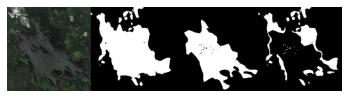

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.23356989


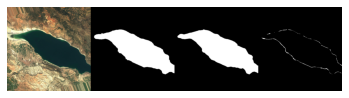

In [17]:
def plot_mask_prediction(files, path, label_path, model):
    plt.axis('off')
    picked_file = np.random.choice(files)
    infile = path + "/data/" + picked_file
    raw = Image.open(infile)
    raw = np.array(raw.resize((512, 512)))/255.
    
    ground_truth_file = label_path + "/data/" + picked_file + "_mask.jpg"
    ground_truth_raw = Image.open(ground_truth_file)
    ground_truth_raw = np.array( ground_truth_raw.resize( (512, 512) ) )
    ground_truth_raw = np.max(np.array(ground_truth_raw),axis=2)
    
    ground_truth_raw = (ground_truth_raw>200).astype('int')
    ground_truth_raw = np.stack((ground_truth_raw,)*3, axis=-1)  # turn into RGB
#     plt.imshow(ground_truth_raw)
#     plt.show()

    y_pred = tf.keras.backend.cast(raw > 0.5, 'float32')
    
    meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
    meanIoU.update_state(y_pred, ground_truth_raw)
    print(meanIoU.result().numpy())

    #predict the mask 
    pred = 255 * model.predict(np.expand_dims(raw, 0)).squeeze()

    #mask post-processing 
    predicted_msk  = (pred > 60).astype('int') #100       
    predicted_msk = np.stack((predicted_msk,)*3, axis=-1)  # turn into RGB

#     plt.imshow(predicted_msk)
#     plt.show()

    #show the mask and the segmented image 
    combined = np.concatenate([raw, 
                               predicted_msk, 
                               ground_truth_raw, 
                               predicted_msk - ground_truth_raw ], 
                              axis = 1)
    plt.imshow(combined)
    plt.show()
    
    
plot_mask_prediction(nwpu_test_files, TRAIN_DIR + "nwpu_images", TRAIN_DIR + "nwpu_label_images", model_nwpu)
plot_mask_prediction(s2_test_files, TRAIN_DIR + "s2cloudless_imagery", TRAIN_DIR + "s2cloudless_label_imagery", model_s2)